## Load data without using threads

In [ ]:
# Load_Data_To_DB.py

# TODO: since inserting data to a database is I/O task --> think about threading/async?
# TODO: think about column names transformation before loading

from abc import ABC, abstractmethod
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Table, Boolean, Numeric
from contextlib import contextmanager
import pandas as pd
from sqlalchemy.exc import IntegrityError


class DatabaseLoadException(Exception):
    pass

class LoadToDatabase(ABC):
    def __init__(self, file_name: str, credentials: str):
        self.file_name = file_name
        self.credentials = credentials

    @abstractmethod
    def db_engine(self, credentials: str):
        """Create engine to connect to database"""
        pass

    @abstractmethod
    def map_table(self, dataframe):
        """Extract columns names from dataframe to create new table."""
        pass

    @abstractmethod
    def create_table(self, table_name, dataframe, schema='public'):
        """Generate ddl script to create a new table in database."""
        self.table_name = table_name
        self.dataframe = dataframe
        self.schema = schema
        pass

    @abstractmethod
    def get_session(self):
        """Provide a transactional scope around a series of operations."""
        pass

    @abstractmethod
    def insert_data(self):
        """Load transformed data from generated to database."""
        pass

    # TODO: think about how to check wheather the table exists in Database
    # @abstractmethod
    # def if_exists_table_in_db(self):
    #     pass


class LoadDataToPostgres(LoadToDatabase):

    def db_engine(self, credentials):
        try:
            engine = create_engine(self.credentials)
            return engine
        except Exception as e:  # TODO: thonk about particular exceptions which may occur
            raise DatabaseLoadException(f'An error occurred: {e}')

    def map_table(self, dataframe):
        # extract necessary columns from df
        columns = {column: self.get_column_data_type(dataframe[column]) for column in dataframe.columns}

        return columns

    def create_table(self, table_name, dataframe, columns, schema='public'):
        metadata = MetaData(schema=schema)

        # Create Column objects for each column in the dictionary
        table_columns = [Column(name, dtype) for name, dtype in columns.items()]

        # Create the table using the provided table_name, metadata, and columns
        table = Table(table_name, metadata, *table_columns)

        # Create the table in the database
        ddl_create_table = metadata.create_all(self.db_engine(self.credentials))

        # Return the created table
        return table

    def get_column_data_type(self, column_series):
        """Map pandas data types to SQLAlchemy data types."""
        types = {
            'int64': Integer,
            'float64': Numeric,
            'object': String,
            'bool': Boolean
        }

        # Get the data type of the column and map it to SQLAlchemy type
        pandas_data_type = str(column_series.dtype)
        sqlalchemy_data_type = types.get(pandas_data_type, String)

        return sqlalchemy_data_type()

    @contextmanager
    def get_session(self):
        from sqlalchemy.orm import sessionmaker
        Session = sessionmaker()
        Session.configure(bind=self.db_engine(self.credentials))
        session = Session()

        try:
            yield session
            session.commit()
        except:
            session.rollback()
            raise DatabaseLoadException(f'Session is rollbacked. An error occur.')
        finally:
            session.close()

    def insert_data(self, table_name, dataframe, schema='public'):

        with self.get_session() as session:
            # Load the table metadata from the existing table
            metadata = MetaData(schema=schema)
            table = Table(table_name, metadata, autoload=True, autoload_with=self.db_engine(self.credentials))

            # Iterate through the DataFrame rows and insert them into the table
            for _, row in dataframe.iterrows():
                record = {key: value for key, value in row.items() if key in table.columns}
                try:
                    session.execute(table.insert().values(record))
                except IntegrityError:
                    session.rollback()
                    print("Integrity Error: Duplicate record or missing required field.")
                except Exception as e:  # TODO: think about particular exceptions
                    session.rollback()
                    print("An error occurred:", e)

            print('Data is successfully loaded.')


class LoadDataToSnowflake(LoadToDatabase):

    def get_session(self):
        from snowflake.snowpark import Session
        pass


In [ ]:
# Launch_Loading_To_Postgres.py

from load_to_database_package.Load_Data_To_DB import LoadDataToPostgres
from config.credentials_variables_postgres import username, password, host, database, port
from read_transformed_data_package.Read_transformed_Data import ReadCsv
import time

if __name__ == '__main__':
    data_to_load = ReadCsv(file_name="../transformed_datasets/smiles_transformed.csv")

    credentials = f"postgresql://{username}:{password}@{host}:{port}/{database}"

    # Create an instance of LoadDataToPostgres
    data_loader = LoadDataToPostgres(file_name="../transformed_datasets/smiles_transformed.csv",
                                     credentials=credentials)

    # Map table columns and types
    columns_info = data_loader.map_table(data_to_load.read_file())

    # Create the table in the database
    data_loader.create_table('molecule_characteristic_3', dataframe=data_to_load.read_file(), columns=columns_info)

    # Insert data into the database
    start_t = time.time()
    data_loader.insert_data(table_name='molecule_characteristic_3', dataframe=data_to_load.read_file())
    end_t = time.time()

    print('Process takes', end_t - start_t, ' seconds')

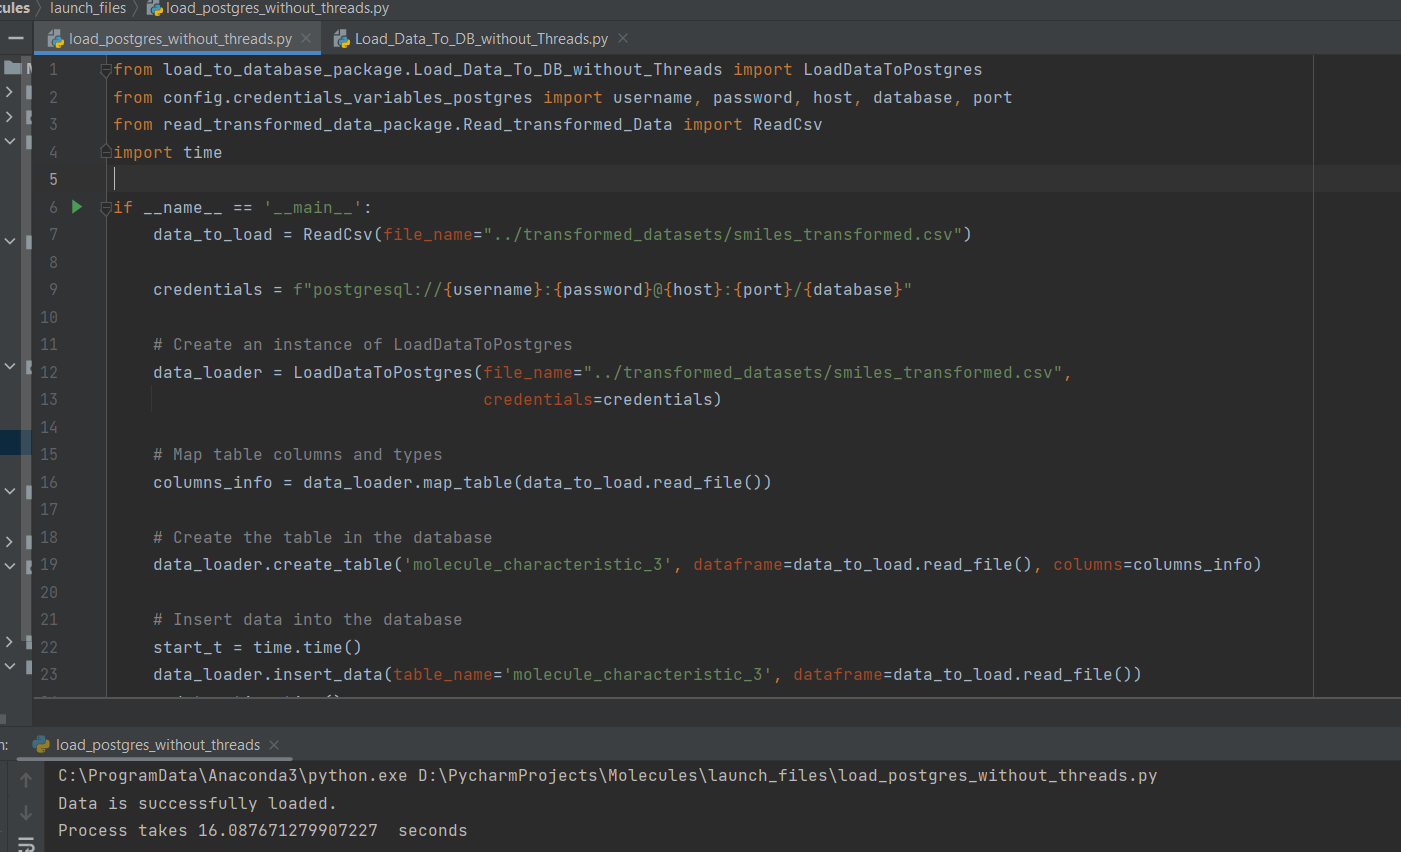

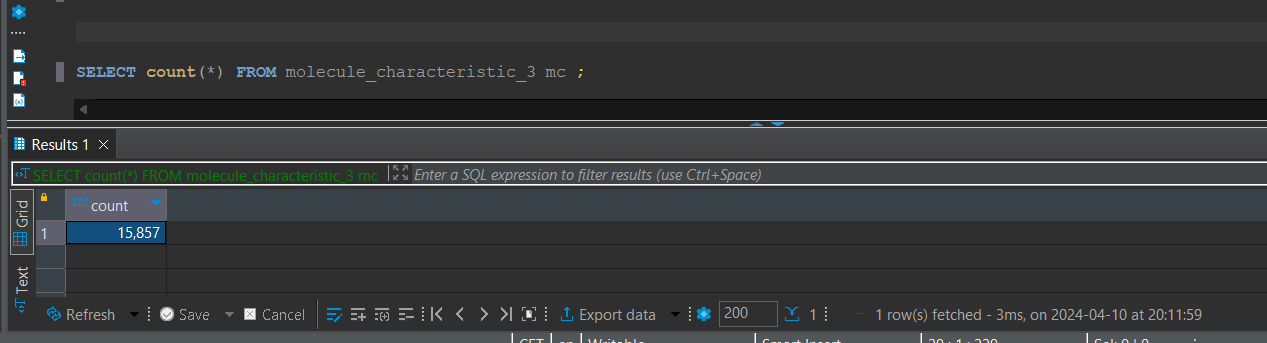

Let`s truncate table:

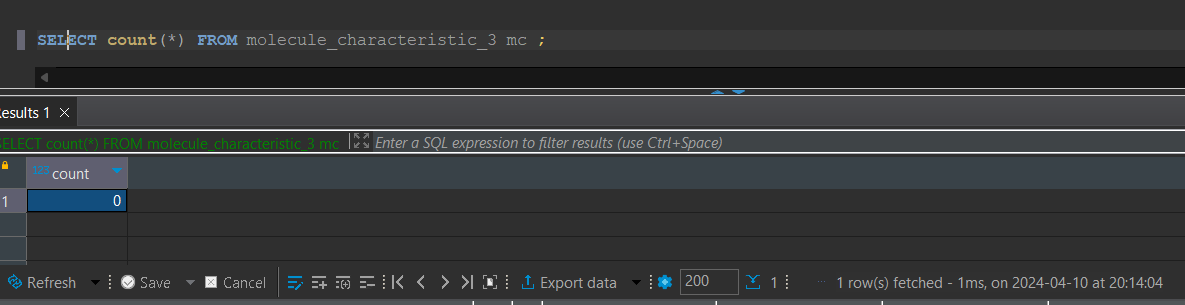

## Load data using Threads

insert_data() method was changed:

In [ ]:
# Load_Data_To_DB.py

from abc import ABC, abstractmethod
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Table, Boolean, Numeric
from contextlib import contextmanager
import pandas as pd
from sqlalchemy.exc import IntegrityError
from concurrent.futures import ThreadPoolExecutor


class DatabaseLoadException(Exception):
    pass

class LoadToDatabase(ABC):
    def __init__(self, file_name: str, credentials: str):
        self.file_name = file_name
        self.credentials = credentials

    @abstractmethod
    def db_engine(self, credentials: str):
        """Create engine to connect to database"""
        pass

    @abstractmethod
    def map_table(self, dataframe):
        """Extract columns names from dataframe to create new table."""
        pass

    @abstractmethod
    def create_table(self, table_name, dataframe, schema='public'):
        """Generate ddl script to create a new table in database."""
        self.table_name = table_name
        self.dataframe = dataframe
        self.schema = schema
        pass

    @abstractmethod
    def get_session(self):
        """Provide a transactional scope around a series of operations."""
        pass

    @abstractmethod
    def insert_data(self):
        """Load transformed data from generated to database."""
        pass

    # TODO: think about how to check wheather the table exists in Database
    # @abstractmethod
    # def if_exists_table_in_db(self):
    #     pass


class LoadDataToPostgres(LoadToDatabase):

    def db_engine(self, credentials):
        try:
            engine = create_engine(self.credentials)
            return engine
        except Exception as e:  # TODO: thonk about particular exceptions which may occur
            raise DatabaseLoadException(f'An error occurred: {e}')

    def map_table(self, dataframe):
        # extract necessary columns from df
        columns = {column: self.get_column_data_type(dataframe[column]) for column in dataframe.columns}

        return columns

    def create_table(self, table_name, dataframe, columns, schema='public'):
        metadata = MetaData(schema=schema)

        # Create Column objects for each column in the dictionary
        table_columns = [Column(name, dtype) for name, dtype in columns.items()]

        # Create the table using the provided table_name, metadata, and columns
        table = Table(table_name, metadata, *table_columns)

        # Create the table in the database
        ddl_create_table = metadata.create_all(self.db_engine(self.credentials))

        # Return the created table
        return table

    def get_column_data_type(self, column_series):
        """Map pandas data types to SQLAlchemy data types."""
        types = {
            'int64': Integer,
            'float64': Numeric,
            'object': String,
            'bool': Boolean
        }

        # Get the data type of the column and map it to SQLAlchemy type
        pandas_data_type = str(column_series.dtype)
        sqlalchemy_data_type = types.get(pandas_data_type, String)

        return sqlalchemy_data_type()

    @contextmanager
    def get_session(self):
        from sqlalchemy.orm import sessionmaker
        Session = sessionmaker()
        Session.configure(bind=self.db_engine(self.credentials))
        session = Session()

        try:
            yield session
            session.commit()
        except:
            session.rollback()
            raise DatabaseLoadException(f'Session is rollbacked. An error occur.')
        finally:
            session.close()

    # ADDED ThreadPoolExecutor
    def insert_data(self, table_name, dataframe, schema='public', threads_num=2):

        def insert_chunk(chunk):
            with self.get_session() as session:
                # Load the table metadata from the existing table
                metadata = MetaData(schema=schema)
                table = Table(table_name, metadata, autoload=True, autoload_with=self.db_engine(self.credentials))

                # Iterate through the chunk rows and insert them into the table
                for _, row in chunk.iterrows():
                    record = {key: value for key, value in row.items() if key in table.columns}
                    try:
                        session.execute(table.insert().values(record))
                    except IntegrityError:
                        session.rollback()
                        print("Integrity Error: Duplicate record or missing required field.")
                    except Exception as e:  # TODO: think about particular exceptions
                        session.rollback()
                        print("An error occurred:", e)

                print('Data is successfully loaded.')

        chunk_size = len(dataframe) // threads_num
        chunks = [dataframe[i:i + chunk_size] for i in range(0, len(dataframe), chunk_size)]

        with ThreadPoolExecutor(max_workers=threads_num) as executor:
            executor.map(insert_chunk, chunks)



class LoadDataToSnowflake(LoadToDatabase):

    def get_session(self):
        from snowflake.snowpark import Session
        pass

In [ ]:
# Launch_Loading_To_Postgres.py

from load_to_database_package.Load_Data_To_DB import LoadDataToPostgres
from config.credentials_variables_postgres import username, password, host, database, port
from read_transformed_data_package.Read_transformed_Data import ReadCsv
import time

if __name__ == '__main__':
    data_to_load = ReadCsv(file_name="../transformed_datasets/smiles_transformed.csv")

    credentials = f"postgresql://{username}:{password}@{host}:{port}/{database}"

    # Create an instance of LoadDataToPostgres
    data_loader = LoadDataToPostgres(file_name="../transformed_datasets/smiles_transformed.csv",
                                     credentials=credentials)

    # Map table columns and types
    columns_info = data_loader.map_table(data_to_load.read_file())

    # Create the table in the database
    data_loader.create_table('molecule_characteristic_3', dataframe=data_to_load.read_file(), columns=columns_info)

    # Insert data into the database
    start_t = time.time()
    data_loader.insert_data(table_name='molecule_characteristic_3', dataframe=data_to_load.read_file(), threads_num=4)
    end_t = time.time()

    print('Process takes', end_t - start_t, ' seconds')

If we do not provide threads amount and use default value (2 threads):

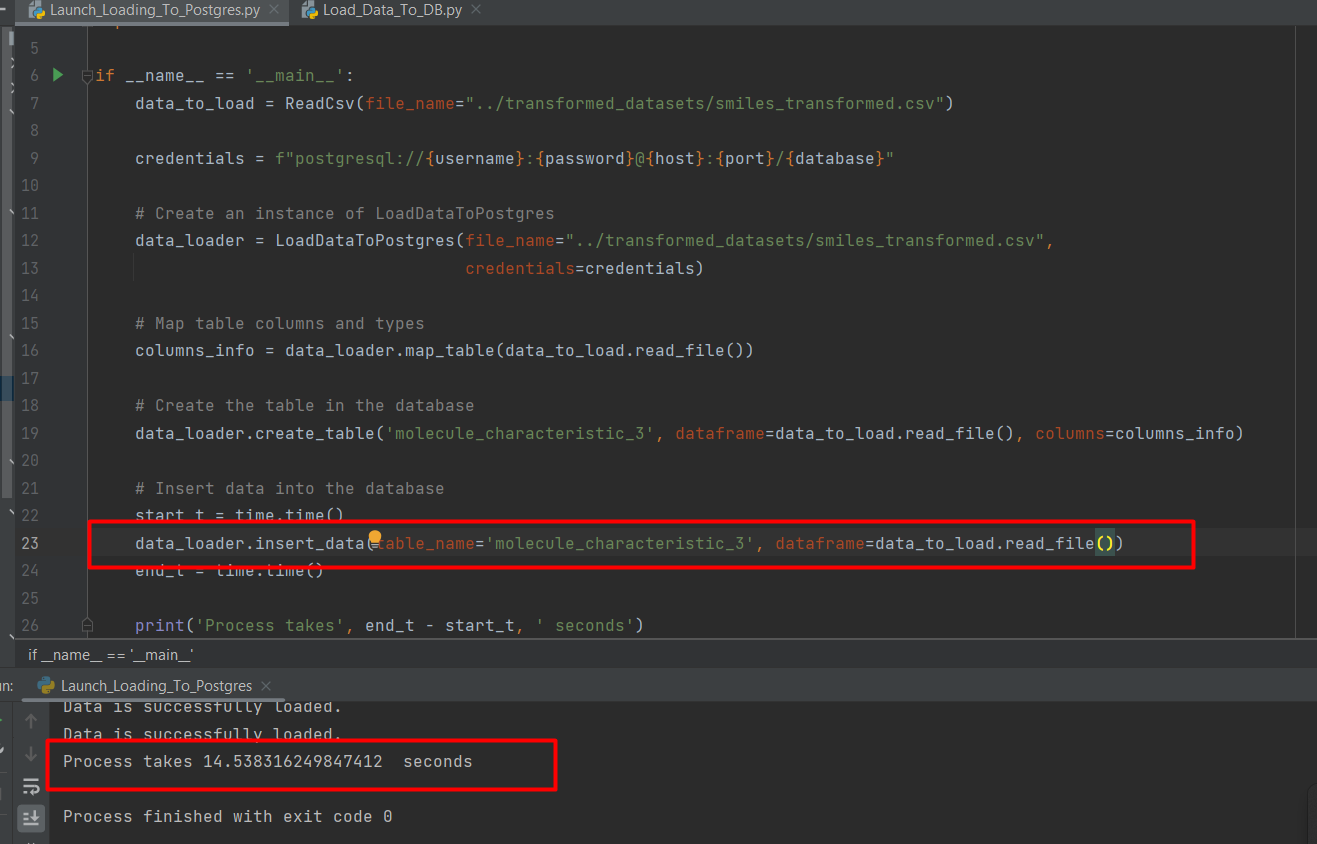

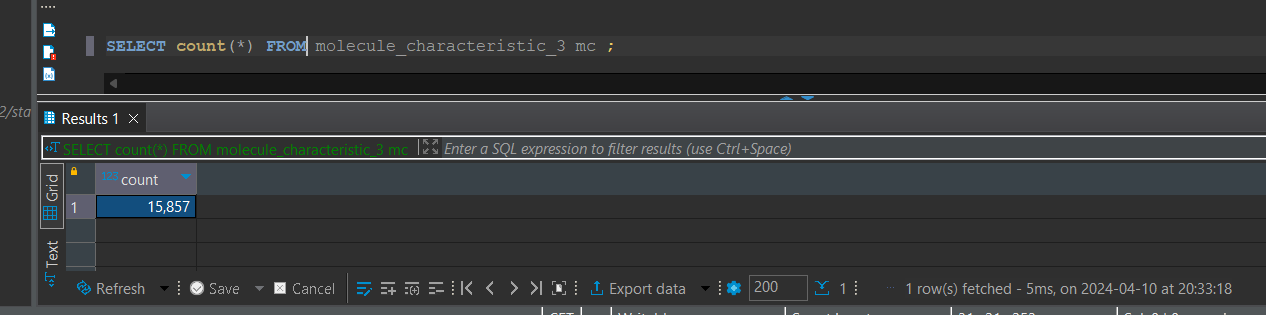

Using 4 threads:

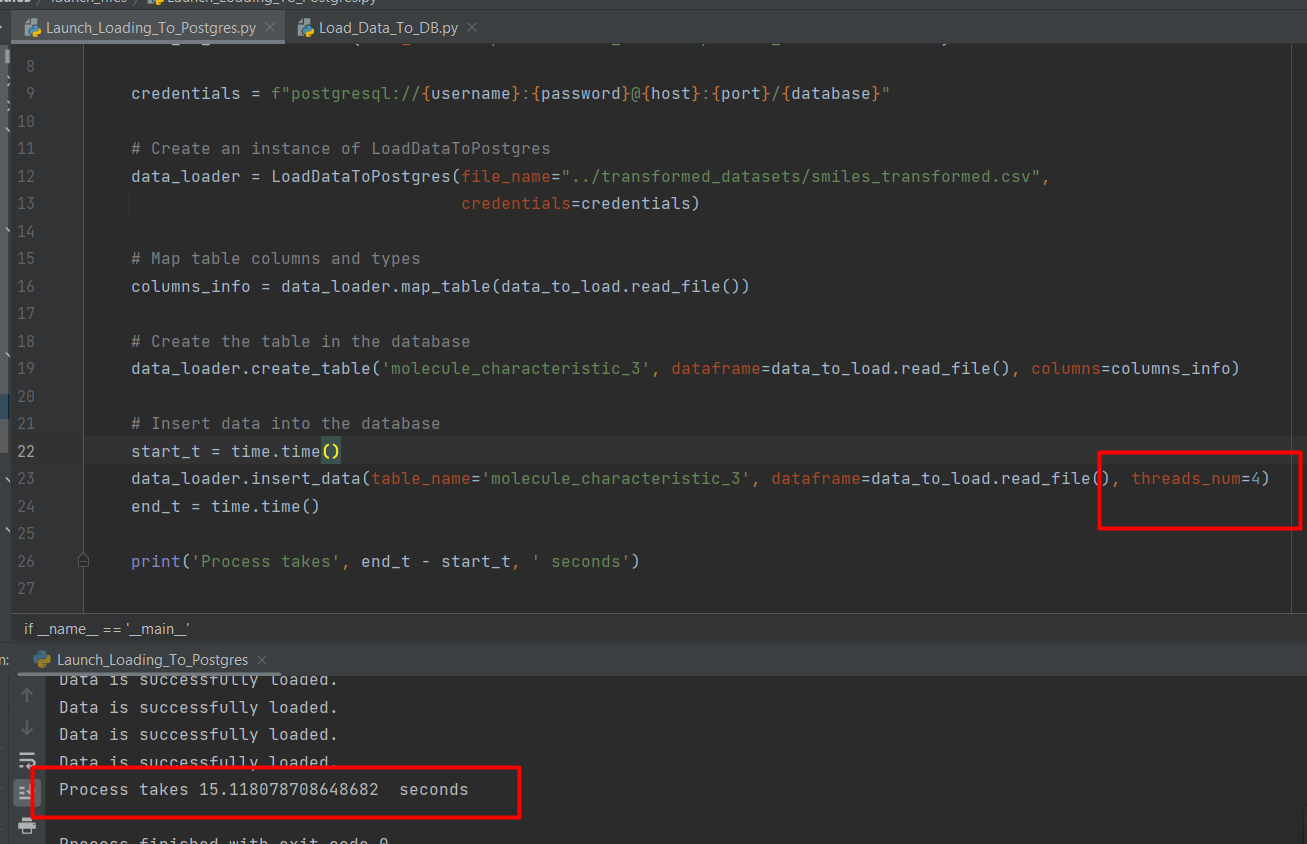

Seems it does not make a lot of sense
TODO: add threading in read_csv() to get several dataframes from dataset and then using threading load them to DB + test it